In [1]:
import numpy as np
import pandas as pd
import sentence_transformers
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import bertopic
import spacy
from transformers import pipeline
import string
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

In [2]:
df_news = pd.read_json('data/cc_gw_news_blogs_2021-10-01_2021-10-31.json')

# For testing purposes, you might find it helpful to cut this dataset down to only the first few articles.
df_news = df_news.iloc[:800]

## Challenge 1: Identifying characteristic words.
One of the most valuable applications of TF-IDF is to use the IDF weighting to provide an explainable way to highlight the terms that are key to a given document. This can even be done across a group of documents, such as all those articles that are produced by the same news source.

Explore the articles present in the provided example data and determine the five most characteristic words for each source. You should:
1. Identify the total list of sources in the dataset.
2. Group the article texts together to create a document for each source.
3. Calculate the TF-IDF vectors for each source. Consider the use of custom stopword sets.
4. Identify the tokens with maximum weight in each vector.

Hint: TF-IDF methods include two parameters that affect the results: `max_df` and `min_df`. Review how they affect the results.

In [3]:
import tqdm
#1. Get the list of all sources.
# The source column has most of this, but we need to process the data a little first.
df_news['source_uri'] = [u['uri'] for u in df_news.source]  ## Alternatively, set() could be applied to the list comprehension, but it's useful to save this.
unique_sources = df_news['source_uri'].unique()
print(unique_sources[:10])

['haidagwaiiobserver.com' 'worldbank.org' 'eurasiareview.com'
 'stettlerindependent.com' 'reliefweb.int' 'bloombergquint.com'
 'catholicnewsagency.com' 'cranbrooktownsman.com' 'dailyecho.co.uk'
 'conservativeangle.com']


In [4]:
#2. Group the article texts for each source into one document.
# For now we'll record this in a dictionary domain: string to keep the link between source and the full text.
source_text = {}
for u in tqdm.tqdm(unique_sources):  # tqdm is very handy to add a progress bar and indicate roughly how long it will take to execute this for loop.
    df_u = df_news[df_news.source_uri==u]
    source_text[u] = ' '.join(df_u.body)
print(source_text['dailyecho.co.uk'][:100])

100%|██████████████████████████████| 509/509 [00:00<00:00, 628.90it/s]

Charles is expected to call for a "vast military-style campaign" to address urgent environmental iss


In [5]:
#3. Calculate the TF-IDF vectors for the sources. Consider the use of custom stop words.
# We should first define our list of stopwords, then we can just apply the example code we saw before.
from sklearn.feature_extraction import _stop_words
stop = list(_stop_words.ENGLISH_STOP_WORDS) + ['climate', 'change', 'global', 'warming']  ## These terms should be removed as they're part of our search terms.
stop += ['comment', 'subscribe', 'cookie', 'accept', 'reject']  ## Add in some terms that might appear from online data quirks (not at all an exhaustive list).

tf_vectorizer = TfidfVectorizer(stop_words=stop,max_df=0.5,min_df=10) ## Using max_df and min_df we automatically ignore terms in more than half of all sources and in fewer than 10 sources.
X_tf = tf_vectorizer.fit_transform([source_text[u] for u in unique_sources])  ## We need to use this list comprehension to ensure that the order matches.
print(tf_vectorizer.get_feature_names_out())

['000' '10' '100' ... 'zero' 'zeshan' 'zone']


In [6]:
#4. Identify the tokens with maximum weight in each document.
# Each row in X_tf corresponds to a particular source, whereas the columns refer to the feature names (i.e. words).
feature_names = tf_vectorizer.get_feature_names_out()

source_key_terms = {}
for i,u in enumerate(unique_sources):
    max_cols = np.argsort(X_tf[i].toarray())  ## We need to make a dense array for the sorting function to work.
    source_key_terms[u] = [feature_names[j] for j in max_cols[0,-5:]]

print(source_key_terms['dailyecho.co.uk'])
print(source_key_terms['worldbank.org'])
print(source_key_terms['conservativeangle.com'])

['action', 'health', 'pollution', 'ride', 'air']
['facility', 'bank', 'insurance', 'disaster', 'risk']
['program', 'biden', 'blinken', 'americans', 'iran']


In [7]:
source_key_terms['timberbiz.com.au']

['credits', 'zealand', 'forests', 'wood', 'forest']

In [8]:
# We can see from checking through these key terms that we can begin to characterise the sources based on the types of words that they prefer to use.
# This can reveal elements of topic focus or region of interest or political leaning from even just a few most characteristic terms.
# This is an application that really benefits from having a big dataset. You need to see a lot of content to start getting enough term frequency to 
# see the most important terms.
# One key thing that should be clear here is the explainability of TF-IDF. We can link our statistical results back to the very tokens we started with.
# This is a key advantage of these simpler methods over transformers!

## Challenge 2: n-gram construction.
Words are not the only sub-sentence unit used to study linguistic patterns in natural language processing. A more general unit called an `n-gram` defines sequences of `n` consecutive words extracted from a text. For example, `2-grams` or `bigrams` are pairs of words appearing consecutively in a given string. More concretely, given the text `This is example text` would return the following bigrams: `this is`, `is example`, `example text`.

Using different values of `n`, look for different n-gram patterns appearing the the titles and body text for the provided example dataset. You should:
1. Write a custom function to calculate all n-grams of a given string. This function should include optional stopword removal.
2. Compare the bigram frequency values both before and after removing stopwords from the text.
3. Find the most frequent 4-grams that include `climate` and the most frequent 4-grams that include `change`. Determine the overlap between these sets of 4-grams (i.e. those that include both `climate` and `change`.
4. Find the the set of 5-grams that contain `climate`. After partitioning the example dataset into one-day windows, can you see any patterns in how the usage of `climate` varies over time? Hint: you will need a larger sample or different sampling strategy to see more than one day included in the data.

In [9]:
#1. Write a custom n-gram extraction function.
# This function should take a string and integer as inputs, along with an optional list of stopwords.

def get_n_grams(s,n,stopwords=None):
    """ Extract all n-grams of the given string, optionally removing stopwords first. 
        
        Inputs:
        s - string, the text to be split into stopwords.
        n - integer, the size of n-gram to be recovered.
        stopwords - list of strings (optional), a set of stopwords to be removed. """

    s = s.lower()
    words = s.split() # By default, split separates the string on spaces. There are other ways to convert a sentence into words however.

    if stopwords != None:
        words = [w for w in words if w not in stopwords]  # It's important to note that we are preserving the order here, some methods will give a bag of words!

    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]  # This returns sliding windows over the final word set.

print(get_n_grams('This is example text',2))
print(get_n_grams('This is example text',2,['is']))

# Note that nltk has a function that does some of this, but expects slightly different inputs.

['this is', 'is example', 'example text']
['this example', 'example text']


In [10]:
#2. Compare the bigram frequency both before and after removing stopwords from the text.
# We should first define our set of stopwords, then we can apply the function we just wrote (or any equivalent) to get the set of stopwords.

import collections
from sklearn.feature_extraction import _stop_words

stop = list(_stop_words.ENGLISH_STOP_WORDS) + ['climate', 'change', 'global', 'warming']  ## These terms should be removed as they're part of our search terms.
stop += ['comment', 'subscribe', 'cookie', 'accept', 'reject']  ## Add in some terms that might appear from online data quirks (not at all an exhaustive list).
stop += ['breaking','news','says']  ## Add some news specific terms that are more likely to appear in headlines.

title_bigrams = collections.Counter([b for t in df_news.title for b in get_n_grams(t,2)])
print(f'Most common bigrams in titles without stopword removal: {title_bigrams.most_common(5)}')

title_bigrams = collections.Counter([b for t in df_news.title for b in get_n_grams(t,2,stop)])
print(f'Most common bigrams in titles with stopword removal: {title_bigrams.most_common(5)}')

body_bigrams = collections.Counter([b for t in df_news.body for b in get_n_grams(t,2)])
print(f'Most common bigrams in bodies without stopword removal: {body_bigrams.most_common(5)}')

body_bigrams = collections.Counter([b for t in df_news.body for b in get_n_grams(t,2,stop)])
print(f'Most common bigrams in bodies with stopword removal: {body_bigrams.most_common(5)}')

## It should be clear here that the removal of stopwords is very important, without this step you will start to see common English constructions as the most frequent patterns.

Most common bigrams in titles without stopword removal: [('climate change', 88), ('progress made', 75), ('made at', 75), ('at g20,', 73), ('canada wanted', 73)]
Most common bigrams in titles with stopword removal: [('canada wanted', 73), ('wanted ambitious', 73), ('ambitious plan', 73), ('trudeau progress', 72), ('progress g20,', 72)]
Most common bigrams in bodies without stopword removal: [('of the', 4006), ('in the', 1887), ('to the', 1594), ('at the', 1391), ('climate change', 1302)]
Most common bigrams in bodies with stopword removal: [('prime minister', 649), ('world leaders', 455), ('net zero', 436), ('biden said', 433), ('group 20', 332)]


In [11]:
#3. Find the most frequent 4-grams with 'climate' or 'change' and the intersection of these sets.
# We will have to adjust our stopword set to allow for 'climate' and 'change' for this to work.
# We might even find it is OK to leave the stopwords in - as n increases, the impact of stopwords is likely to decrease.

climate_title_grams = collections.Counter([b for t in df_news.title for b in get_n_grams(t,4) if 'climate' in b])
print(f'Most common "climate" 4-grams in titles: {climate_title_grams.most_common(5)}')

change_title_grams = collections.Counter([b for t in df_news.title for b in get_n_grams(t,4) if 'change' in b])
print(f'Most common "change" 4-grams in titles: {change_title_grams.most_common(5)}')

# The Counter class has short hands for intersection - we can use &.
print(f'\n4-grams using both "climate" and "change": {(climate_title_grams & change_title_grams).most_common(5)}')

climate_body_grams = collections.Counter([b for t in df_news.body for b in get_n_grams(t,4) if 'climate' in b])
print(f'\nMost common "climate" 4-grams in bodies: {climate_body_grams.most_common(5)}')

change_body_grams = collections.Counter([b for t in df_news.body for b in get_n_grams(t,4) if 'change' in b])
print(f'Most common "change" 4-grams in bodies: {change_body_grams.most_common(5)}')

# The Counter class has short hands for intersection - we can use &.
print(f'\n4-grams using both "climate" and "change": {(climate_body_grams & change_body_grams).most_common(5)}')

# Considering these patterns together, we find that "climate" is often used alone or with other terms, whereas this context has a strong bias towards
# "change" appearing after "climate".

Most common "climate" 4-grams in titles: [('trudeau says climate progress', 72), ('says climate progress made', 72), ('climate progress made at', 72), ("ex-un climate chief doesn't", 43), ("climate chief doesn't see", 43)]
Most common "change" 4-grams in titles: [('clock on climate change', 30), ('on climate change and', 23), ('climate change and must', 23), ('change and must act', 23), ('un climate change conference', 6)]

4-grams using both "climate" and "change": [('clock on climate change', 30), ('on climate change and', 23), ('climate change and must', 23), ('un climate change conference', 6), ('climate change conference begins', 6)]

Most common "climate" 4-grams in bodies: [('cop26 climate talks in', 99), ('the fight against climate', 85), ('fight against climate change', 76), ('climate talks in glasgow', 76), ('against climate change than', 74)]
Most common "change" 4-grams in bodies: [('fight against climate change', 76), ('against climate change than', 74), ('climate change t

[('the fight against climate change', 76), ('on the fight against climate', 74), ('fight against climate change than', 74), ('against climate change than others,"', 74), ('cop26 climate talks in glasgow', 74), ('climate change than others," trudeau', 73), ('more ambitious agreement on climate', 71), ('ambitious agreement on climate change', 71), ('agreement on climate change to', 71), ('on climate change to emerge', 71)]


100%|█████████████████████████████████| 31/31 [00:00<00:00, 39.39it/s]


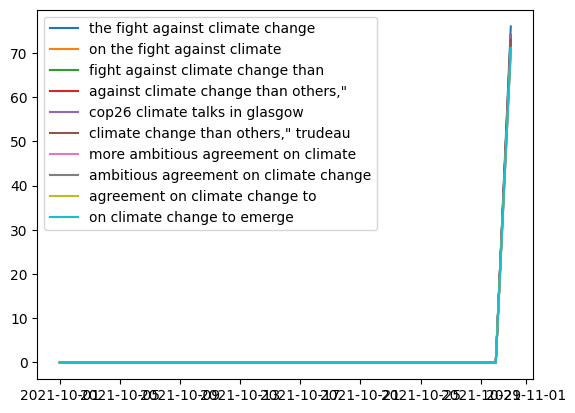

In [12]:
#5. Find the set of five grams containing "climate change" and track their usage patterns between days.
# For ease of checking this (and ensuring we have enough data), we should restrict to only looking at some of the most frequent terms.

body_five_grams = collections.Counter([b for t in df_news.body for b in get_n_grams(t,5) if 'climate' in b])
print(body_five_grams.most_common(10))

day_counts = {k:[] for k,v in body_five_grams.most_common(10)}  # We make a dictionary of terms and the count of the term on each day.
# The easiest way to get the daily rate is to sequentially filter the dataframe.
for day in tqdm.tqdm(range(1,32)):
    df_day = df_news[df_news.date == f'2021-10-{day}']
    day_five_grams = collections.Counter([b for t in df_day.body for b in get_n_grams(t,5) if 'climate' in b])

    for k in day_counts:
        day_counts[k].append(day_five_grams[k])

# Finally we can plot the timeseries for each 5-gram.
import matplotlib.pyplot as plt
dates = pd.date_range('2021-10-01','2021-10-31')
for k in day_counts:
    plt.plot(dates,day_counts[k],label=k)
plt.legend()
plt.show()

In [13]:
# We can see quite clearly that the usage of these terms is not uniformly distributed across the whole month of data.
# There is a large increase in the discussion of "social services and climate change". This happened because of changes to US legislation
# proposed by the Biden administration in this area.
# Many of the other terms are linked to international politics and discussions around climate change - e.g. the IPCC and UNFCCC.

## Challenge 3: Narrative consistency.
Text data can be difficult to work with for many reasons, mainly due to it being noisy and needing careful cleaning. The example data you were given contains a particular issue with portions of the text that may be apparently unrelated to the major themes of the text. This is an inevitable consequence of the data source; it is provided by a service that collects and formats online news articles and this sometimes includes text from web features (e.g. other story links) being incorrectly included in the main text. Luckily, we can use some of the techniques we introduced previously to look for divergence in the semantic content of portions of the text.

Look for evidence of narrative inconsistency in the body text of the example data. You should:
1. Determine an appropriate unit of analysis to partition the article into, and preprocess the data into these units.
2. Describe an algorithm to measure the internal narrative consistency of an article that uses these sub-article units.
3. Apply this algorithm to quantify the narrative consistency of all articles in the example dataset. Which articles are the most and least narratively consistent?

Hint: Consider mapping the semantic space covered by the article. Which articles cover the largest or smallest semantic space?

In [14]:
#1. Determine an appropriate unit of analysis to split the articles into.
## There are two natural choices to split the articles up: sentences or paragraphs. We can try both.
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('sentencizer')
sentences = [list(map(str,nlp(t).sents)) for t in tqdm.tqdm(df_news.body)]
paragraphs = [t.split('\n\n') for t in df_news.body]
## Here we're demonstrating two different methods to manage this splitting - using either basic string methods or more complex langauge models that
## can hanndle more complex text structures.

100%|███████████████████████████████| 800/800 [05:29<00:00,  2.43it/s]


In [15]:
#2. Describe an algorithm for measuring the internal narrative consistency of an article.
## There are a number of ways you could do this. The solution outlined here is designed to consider the semantic space covered by the parts of the article.
def measure_semantic_range(texts,model):
    """ Calculate the mean semantic similarity between all pairs of the provided texts. Higher similiarity means higher semantic consistency.
        Inputs:
        texts - an iterable of strings of all texts to be compared.
        model - an embedding model object.
        Outputs:
        mean - float, the mean pairwise similarity of all texts.
        """

    # Get the text embeddings.
    embeddings = emb_model.encode(texts, show_progress_bar=False)

    # Find the pairwise distances.
    sims = cosine_similarity(embeddings)

    return np.mean(sims)
    
emb_model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')
test_text = ['I like to eat oranges','I like to eat apples']
print(measure_semantic_range(test_text,emb_model))
test_text = ['I like to eat oranges','Juliet went to Paris']
print(measure_semantic_range(test_text,emb_model))
    
## This is one of the simplest possible ways to do this, and collapses the richness of the entire article down into a single numerical value.
## You might try taking the largest or the standard deviation but they each have specific drawbacks. Here we pick the mean so that if most of the
## article is on the same theme, it should give a lower average distance.

0.8466449
0.50020236


In [16]:
#3. Quantify the narrative consistency of all articles in the dataset. Which are most and least consistent?
sent_consistencies = [measure_semantic_range(t,emb_model) for t in tqdm.tqdm(sentences)]
para_consistencies = [measure_semantic_range(t,emb_model) for t in tqdm.tqdm(paragraphs)]

sent_max_consist = np.argmax(sent_consistencies)
print(f'The most sentence-consistent article is {df_news.title.iloc[sent_max_consist]} by {df_news.source_uri.iloc[sent_max_consist]}')

sent_min_consist = np.argmin(sent_consistencies)
print(f'The least sentence-consistent article is {df_news.title.iloc[sent_min_consist]} by {df_news.source_uri.iloc[sent_min_consist]}')

para_max_consist = np.argmax(para_consistencies)
print(f'The most paragraph-consistent article is {df_news.title.iloc[para_max_consist]} by {df_news.source_uri.iloc[para_max_consist]}')

para_min_consist = np.argmin(para_consistencies)
print(f'The least paragraph-consistent article is {df_news.title.iloc[para_min_consist]} by {df_news.source_uri.iloc[para_min_consist]}')

100%|███████████████████████████████| 800/800 [06:57<00:00,  1.92it/s]

The most sentence-consistent article is Success is entirely possible: COP26 opens amid flurry of fresh national climate pledges (michael.holder@incisivemedia.com(Michael Holder)/Business Green) by techinvestornews.com
The least sentence-consistent article is Your Monday Briefing by nytimes.com
The most paragraph-consistent article is UN Climate Change Conference begins by theaustralian.com.au
The least paragraph-consistent article is Your Monday Briefing by nytimes.com


(array([ 24., 104., 230., 268., 108.,  43.,  13.,   4.,   3.,   3.]),
 array([0.11621352, 0.17875826, 0.24130301, 0.30384776, 0.36639249,
        0.42893726, 0.49148202, 0.55402672, 0.61657149, 0.67911625,
        0.74166101]),
 <BarContainer object of 10 artists>)

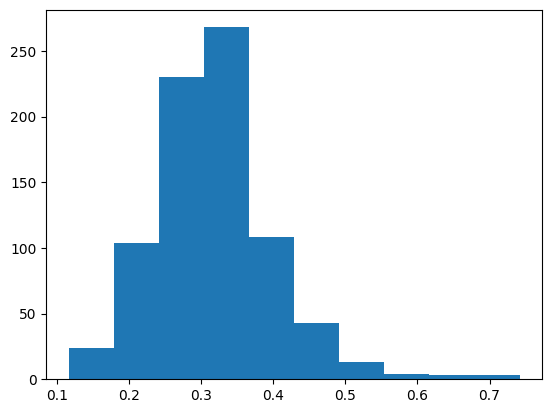

In [17]:
plt.hist(sent_consistencies)
## Looking at the histogram of sentence consistencies tells us something useful. Most of the time, the articles are quite variable (i.e. their
## similarity is comparatively low). There is a longer tail for some of the articles that display a high level of internal consistency.

(array([ 23., 112., 355., 201.,  68.,  18.,   7.,   5.,   1.,  10.]),
 array([0.11670735, 0.20503661, 0.2933659 , 0.38169518, 0.47002444,
        0.55835366, 0.64668298, 0.73501223, 0.82334149, 0.91167074,
        1.        ]),
 <BarContainer object of 10 artists>)

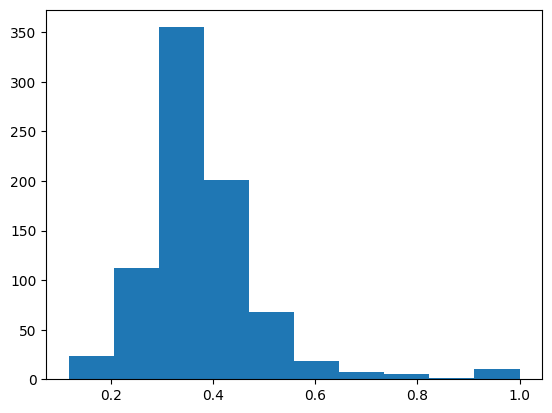

In [18]:
plt.hist(para_consistencies)
## Paragraph-level results are broadly similar, although here the tail for higher values is longer. You should notice a possible weakness with the
## method here. When the article is short, it may only be one sentence or paragraph. As a result, the self-similarity will be very high. This is what
## has happened in the paragraph case here, with the most consistent article having a single paragraph.

## Challenge 4: Positivity and negativity in narratives.
The precise dataset and seeding applied to topic modelling can make a big difference to the results. Sometimes this can mean that the detected topics may miss some of the smaller, more nuanced themes. This means it is often a good idea to consider a few different outputs from topic modelling under a range of paramter values. At this stage, confidence in the model outputs can be determined by aggregate the common patterns appearing across different runs.

Compare the topics identified in different perspectives on the example data. You should:
1. Apply the BERTopic framework with several different parameter combinations in the UMAP and HDBSCAN processes. Do you notice any topics that are consistent over runs?
2. Partition the news dataset into three sets of articles based on valence (i.e. positive, neutral, negative). What proportion of articles fall in each category? How sensitive is this value to the method of sentiment analysis applied?
3. Visualise the semantic space for the entire corpus. Are there any spatial patterns emerging based on the article valence?
4. Apply BERTopic to each subset. Compare the topics found on each subet of the dataset to those found over all texts.

In [19]:
# The embedding process can be quite slow (this depends a lot on your hardware and the size of the dataset).
# We can save a lot of time when experimenting with different parameter combinations by saving and reusing the embeddings.
embed_model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embed_model.encode(df_news.body, show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [20]:
#1. Rerun BERTopic with multiple seeds. Which topics are consistent?
# We can define custom UMAP and HDBSCAN objects for BERTopic.
from umap import UMAP
from hdbscan import HDBSCAN
umap_model = UMAP(n_neighbors=15,  ## This sets the same defaults as BERTopic, except with the addition of a fixed seed.
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = bertopic.BERTopic(umap_model=umap_model,hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(df_news.body,embeddings)

# When varying the parameters on a given sample you should notice a few things. The larger topics should be recovered
# relatively consistently, but the precise sizes and ordering of these topics will vary. The HDBScan parameters will have
# the biggest impact on the number of topics identified since it determines the final clusters.

# The 'noise' topic with label -1 will also vary and can even merge with some of the smaller topics in certain circumstances.
# These topics are typically not considered as important for precisely this reason - in practice only the largest topics
# are explored in any detail.

In [21]:
#2. Partition articles based on sentiment, and proportion of articles in each.
# There are a lot of different sentiment analysis tools, each will be trained for a specific purpose. Selecting the right model is a skill, and it is
# OK to experiment with a few different options before validating them on a known dataset. Here I'm using a general one from HuggingFace, that gives 
# predictions for positive, neutral and negative classes.
sentiment_task = pipeline("sentiment-analysis", model='cardiffnlp/twitter-roberta-base-sentiment-latest', tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest',max_length=512,truncation=True)
sentiments = [sentiment_task(t)[0]['label'] for t in df_news.body] # You will find the article bodies are too long for some transformers so truncation is required! The titles don't
# have much in the way of strong opinion identifiers however. You may also be able to do this more efficiently - certain transformer setups can take lists or series of texts.
df_news['nlp_sent'] = sentiments
df_pos = df_news[df_news.nlp_sent == 'positive']
df_neu = df_news[df_news.nlp_sent == 'neutral']
df_neg = df_news[df_news.nlp_sent == 'negative']

print(f'{100*len(df_pos)/len(df_news)}% of articles are positive.')
print(f'{100*len(df_neu)/len(df_news)}% of articles are neutral.')
print(f'{100*len(df_neg)/len(df_news)}% of articles are negative.')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


11.875% of articles are positive.
79.625% of articles are neutral.
8.5% of articles are negative.


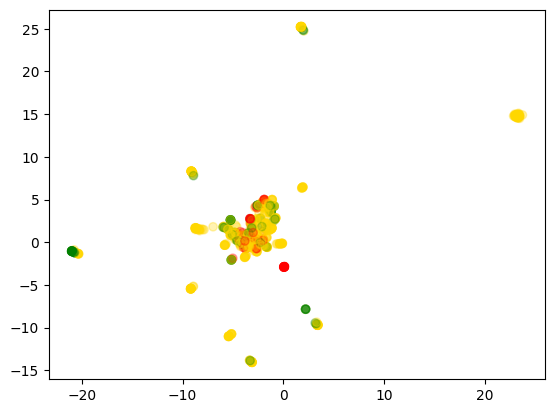

In [22]:
#3. Visualise the semantic space. Where do positive/neutral/negative articles fit in this space?
# Now we have saved the emebddings, we can visualise their relationships spatially. The challenge here is visualising some high dimensional vector
# in 2 or 3 dimensions. This is where dimensionality reduction comes in. There are a few ways to do this - one of which is already included as part
# of BERTopic.
low_dim_model = UMAP(n_neighbors=15,  ## This sets the same defaults as BERTopic, except with the addition of a fixed seed.
            n_components=2,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=42)
emb_2d = low_dim_model.fit_transform(embeddings)

col_map = {'positive':'green','neutral':'gold','negative':'red'}
plt.scatter(emb_2d[:,0],emb_2d[:,1],color=[col_map[s] for s in df_news.nlp_sent],alpha=0.3)

# You should notice in the figure below that there is a separation between a majority positive section and the rest of the texts and likely a few
# floating islands of similar texts. Here we are really looking at two diffent aspects of the text in one space. The spatial layout is linked to the
# meaning of the text, and this is not always directly linked to the sentiment expressed.

# One key thing to note is how the visualisation here will depend exactly on the sample that you use. The example dataset you were provided is sampled
# based on time - it considers articles from a single month. If you filter based on the first/last few articles as I have for some of these example
# solutions, you will find that you are instead looking at a small number of days. Here there might be a lot of similar reporting based on major climate
# news events such as political meetings. As you add in more data, you might find that the sepration of different data points disappears - i.e. there
# isn't much semantic difference between texts based purely on their sentiment.

# The final note here - you might wonder why some of the points are very solid for being plotted with a low opacity. This is due to the nature of news
# data. Many outlets will report on the same event, or even share syndicated content. As a result, it's not impossible to see repeated or very similar
# texts that produce the same 2D embeddings - this is a feature of the data and not a bug!

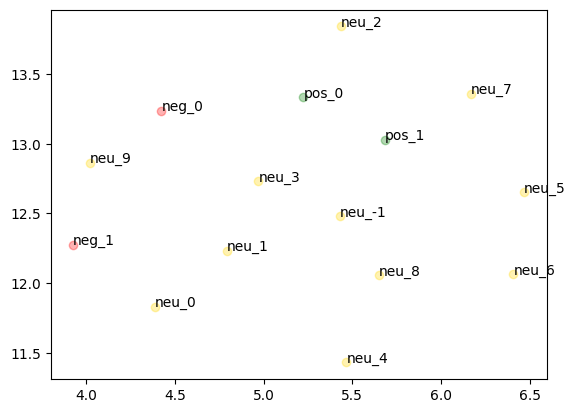

In [23]:
#4. Run BERTopic over the subsets and compare to topics over all articles.
# Comparing the topic assignments can be done in a few ways. How close are they in meaning (both qualitatively and quantiatively)?
# When comparing against the topics found over all the data, we may want to consider how much the labelling agrees.
pos_topics,pos_probs = topic_model.fit_transform(df_pos.body,embeddings=embeddings[df_news[df_news.nlp_sent == 'positive'].index,:])
pos_topic_info = topic_model.get_topic_info()
pos_topic_vecs = topic_model.topic_embeddings_
neu_topics,neu_probs = topic_model.fit_transform(df_neu.body,embeddings=embeddings[df_news[df_news.nlp_sent == 'neutral'].index,:])
neu_topic_info = topic_model.get_topic_info()
neu_topic_vecs = topic_model.topic_embeddings_
neg_topics,neg_probs = topic_model.fit_transform(df_neg.body,embeddings=embeddings[df_news[df_news.nlp_sent == 'negative'].index,:])
neg_topic_info = topic_model.get_topic_info()
neg_topic_vecs = topic_model.topic_embeddings_

# The first thing we'll try is plotting the topic centroids for each set, labelled with their topic number.
vecs_2d = low_dim_model.fit_transform(np.vstack([pos_topic_vecs,neu_topic_vecs,neg_topic_vecs]))

plt.scatter(vecs_2d[:len(pos_topic_info),0],vecs_2d[:len(pos_topic_info),1],color='green',alpha=0.3)
plt.scatter(vecs_2d[len(pos_topic_info):len(pos_topic_info)+len(neu_topic_info),0],vecs_2d[len(pos_topic_info):len(pos_topic_info)
    +len(neu_topic_info),1],color='gold',alpha=0.3)
plt.scatter(vecs_2d[len(pos_topic_info)+len(neu_topic_info):len(pos_topic_info)+len(neu_topic_info)+len(neg_topic_info),0],vecs_2d[len(pos_topic_info)
    +len(neu_topic_info):len(pos_topic_info)+len(neu_topic_info)+len(neg_topic_info),1],color='red',alpha=0.3)

# Add labels to the points
ax = plt.gca()
for v,l in zip(vecs_2d,[f'pos_{n}' for n in pos_topic_info.Topic]+[f'neu_{n}' for n in neu_topic_info.Topic]+[f'neg_{n}' for n in neg_topic_info.Topic]):
    ax.text(v[0],v[1],l)

# This should show again that topic and sentiment can be unrelated - the majority neutral class will cover most of the space, although some of the
# negative and positive topics might align. Using the topic labels we can get some pointers of those that might be similar to read.

In [24]:
pos_topic_info[pos_topic_info.Topic == 1].Representative_Docs.iloc[0][0][:]
neu_topic_info[neu_topic_info.Topic == 0].Representative_Docs.iloc[0][0][:]
neg_topic_info[neg_topic_info.Topic == 1].Representative_Docs.iloc[0][0][:]
# For example, these three topics are all about US politics and report on Joe Biden's actions. It's not surprising that this is a theme that cuts
# different sentiment classes. American politics generates a lot of news coverage and it can be very divisive.

'Labour\'s shadow energy secretary also said Alok Sharma, the MP who is serving as the president of the climate change conference, is being undermined by his colleagues in the UK Government.\n\nMr Miliband spoke at the premiere of The Green Planet, a new television series by Sir David Attenborough.\n\nThe premiere was held in Glasgow on Sunday evening in the Cop26 summit\'s Green Zone.\n\nMr Miliband told the PA news agency: "We know what the task is, this decade - to halve global emissions.\n\n"Now Glasgow may not get all the way there but we have to get as far as we possibly can.\n\n"And that\'s going to require tough conversations with some leaders who are not doing enough.\n\n"The experts tell us no G20 country is doing enough, so everybody\'s got to step up."\n\nHe continued: "We don\'t want a greenwash summit, we don\'t want a climate delay summit, we want a climate delivery summit."\n\nThe former Labour leader said policies like the cut in air passenger duty, which was announced

In [25]:
# To compare with the topics identified over the full dataset, we will use a method to check agreement. There are a few, but here we will try
# NMI - normalised mutual information.
from sklearn.metrics.cluster import normalized_mutual_info_score

# We need to compile the topic labels as a single vector over all articles. It will be easiest to add this to the original dataframe to make sure we
# apply the sentiment level topics to the right texts.
df_news['full_topic'] = topics
uri_to_sent_topic = {}  # The uris are unique identifiers, so we use these to make sure we are labelling the correct text.
for (i,row),topic in zip(df_pos.iterrows(),pos_topics):
    uri_to_sent_topic[row.uri] = topic+100
for (i,row),topic in zip(df_neu.iterrows(),neu_topics):
    uri_to_sent_topic[row.uri] = topic+200
for (i,row),topic in zip(df_neg.iterrows(),neg_topics):
    uri_to_sent_topic[row.uri] = topic+300  # I'm using this shift so we don't get confused between the different topic models, the precise labels don't matter.

df_news['sent_topic'] = [uri_to_sent_topic[u] for u in df_news.uri]
normalized_mutual_info_score(df_news.full_topic,df_news.sent_topic)
# The NMI gives you a value in [0,1] where 0 indicates no alignment and 1 indicates perfect agreement. We're unlikely to see perfect agreement given
# the different numbers of topics. You should find that there is a good level of agreement between the topics, which again points towards the themes
# and sentiment being somewhat independent.

0.6775673944283822